In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sqlite3
from scipy.stats.mstats import winsorize
sns.set_style('darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()

In [3]:
# Initialize Basemap
import matplotlib.pyplot as plt
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

In [4]:
# View all columns on the screen
pd.set_option('max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',1000)

## Load trip data from DB
---

### There are 15 million rows in the database

In [5]:
query_string1 = '''
                select * from trips order by pickup_datetime asc
'''

In [6]:
# Connect to the existing fleetriskdb
con = sqlite3.connect('./DB/nyctaxidb.sqlite')
# Confirm data is being returned from this query
trip_data_df = pd.read_sql_query(query_string1, con)
# Verify that result of SQL query is stored in the dataframe
trip_data_df.tail()

,index,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
15100463,3246544,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,N,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.981850,40.783993,-73.991020,40.770947
15100464,2942655,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,N,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.976997,40.761559,-74.003853,40.742271
15100465,3007208,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,N,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.979881,40.776081,-73.982071,40.768272
15100466,3007664,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,1,N,2013-04-30 23:59:58,2013-05-01 00:06:38,1,399,1.7,-73.942482,40.779572,-73.942482,40.779572
15100467,3246968,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,N,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-73.998215,40.729637,-73.992798,40.748791


In [7]:
con.close()

In [8]:
trip_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15100468 entries, 0 to 15100467
Data columns (total 15 columns):
index                 int64
medallion             object
hack_license          object
vendor_id             object
rate_code             int64
store_and_fwd_flag    object
pickup_datetime       object
dropoff_datetime      object
passenger_count       int64
trip_time_in_secs     int64
trip_distance         float64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
dtypes: float64(5), int64(4), object(6)
memory usage: 1.7+ GB


In [9]:
trip_data_df.shape[0]

15100468

## Scrub trip data for outliers

In [10]:
# Create a new dataframe for the cleaned trips data
trips_df = trip_data_df.copy()
# Check for nulls
trips_df.isnull().sum()

index                       0
medallion                   0
hack_license                0
vendor_id                   0
rate_code                   0
store_and_fwd_flag    7518657
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
trip_time_in_secs           0
trip_distance               0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude         146
dropoff_latitude          146
dtype: int64

In [11]:
# Let's drop the store_and_fwd_flag column and the null values of latitude and longitude
trips_df = trips_df.drop('store_and_fwd_flag', axis=1)
trips_df.columns

Index([u'index', u'medallion', u'hack_license', u'vendor_id', u'rate_code', u'pickup_datetime', u'dropoff_datetime', u'passenger_count', u'trip_time_in_secs', u'trip_distance', u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude', u'dropoff_latitude'], dtype='object')

In [12]:
trips_df = trips_df[~trips_df.dropoff_latitude.isnull()]
trips_df = trips_df[~trips_df.dropoff_longitude.isnull()]

In [13]:
trips_df.isnull().sum()

index                0
medallion            0
hack_license         0
vendor_id            0
rate_code            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_time_in_secs    0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
dtype: int64

In [14]:
trips_df.describe()

,index,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,1.510032e+07,1.510032e+07,1.510032e+07,1.510032e+07,1.510032e+07,1.510032e+07,1.510032e+07,1.510032e+07,1.510032e+07
mean,7.550236e+06,1.033252e+00,1.709047e+00,7.466153e+02,2.862927e+00,-7.273425e+01,4.006861e+01,-7.269257e+01,4.004795e+01
std,4.359148e+06,3.451034e-01,1.385618e+00,5.504392e+02,3.344191e+00,9.731619e+00,6.956639e+00,9.858587e+00,6.977638e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.323420e+03,-3.481141e+03,-2.771290e+03,-3.547898e+03
25%,3.775086e+06,1.000000e+00,1.000000e+00,3.600000e+02,1.040000e+00,-7.399213e+01,4.073512e+01,-7.399143e+01,4.073417e+01
50%,7.550262e+06,1.000000e+00,1.000000e+00,6.000000e+02,1.780000e+00,-7.398172e+01,4.075281e+01,-7.398007e+01,4.075333e+01
75%,1.132538e+07,1.000000e+00,2.000000e+00,9.600000e+02,3.200000e+00,-7.396676e+01,4.076754e+01,-7.396362e+01,4.076832e+01
max,1.510047e+07,2.100000e+02,9.000000e+00,1.080000e+04,1.000000e+02,2.228722e+03,3.210393e+03,2.228746e+03,3.577126e+03


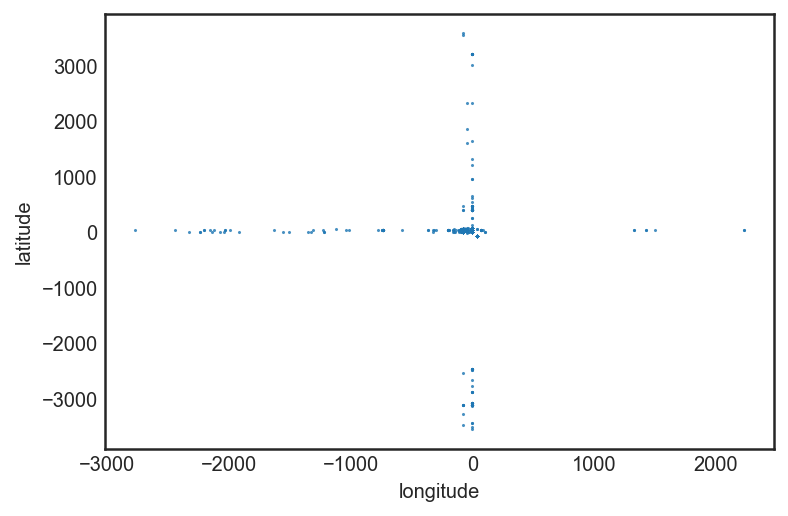

In [15]:
# Sanity Check Latitude and Longitude Values
longitude = list(trips_df.pickup_longitude) + list(trips_df.dropoff_longitude)
latitude = list(trips_df.pickup_latitude) + list(trips_df.dropoff_latitude)

trip_data = pd.DataFrame({'latitude': latitude, 'longitude': longitude})
sns.set_style("white")
ax = sns.regplot(x="longitude", y="latitude", data=trip_data, scatter=True, fit_reg=False, scatter_kws={"s": 0.3})
plt.show()

In [16]:
# We have lots of extraneous points here. Let's pare this down to a latitude/longitude range around NYC
longitude_limit = [-74.027, -73.85]
latitude_limit = [40.67, 40.85]
trips_df2 = trips_df.copy()
trips_df2 = trips_df2[(trips_df2.pickup_longitude.between(longitude_limit[0], longitude_limit[1], inclusive=False))]
trips_df2 = trips_df2[(trips_df2.dropoff_longitude.between(longitude_limit[0], longitude_limit[1], inclusive=False))]
trips_df2 = trips_df2[(trips_df2.pickup_latitude.between(latitude_limit[0], latitude_limit[1], inclusive=False))]
trips_df2 = trips_df2[(trips_df2.dropoff_latitude.between(latitude_limit[0], latitude_limit[1], inclusive=False))]

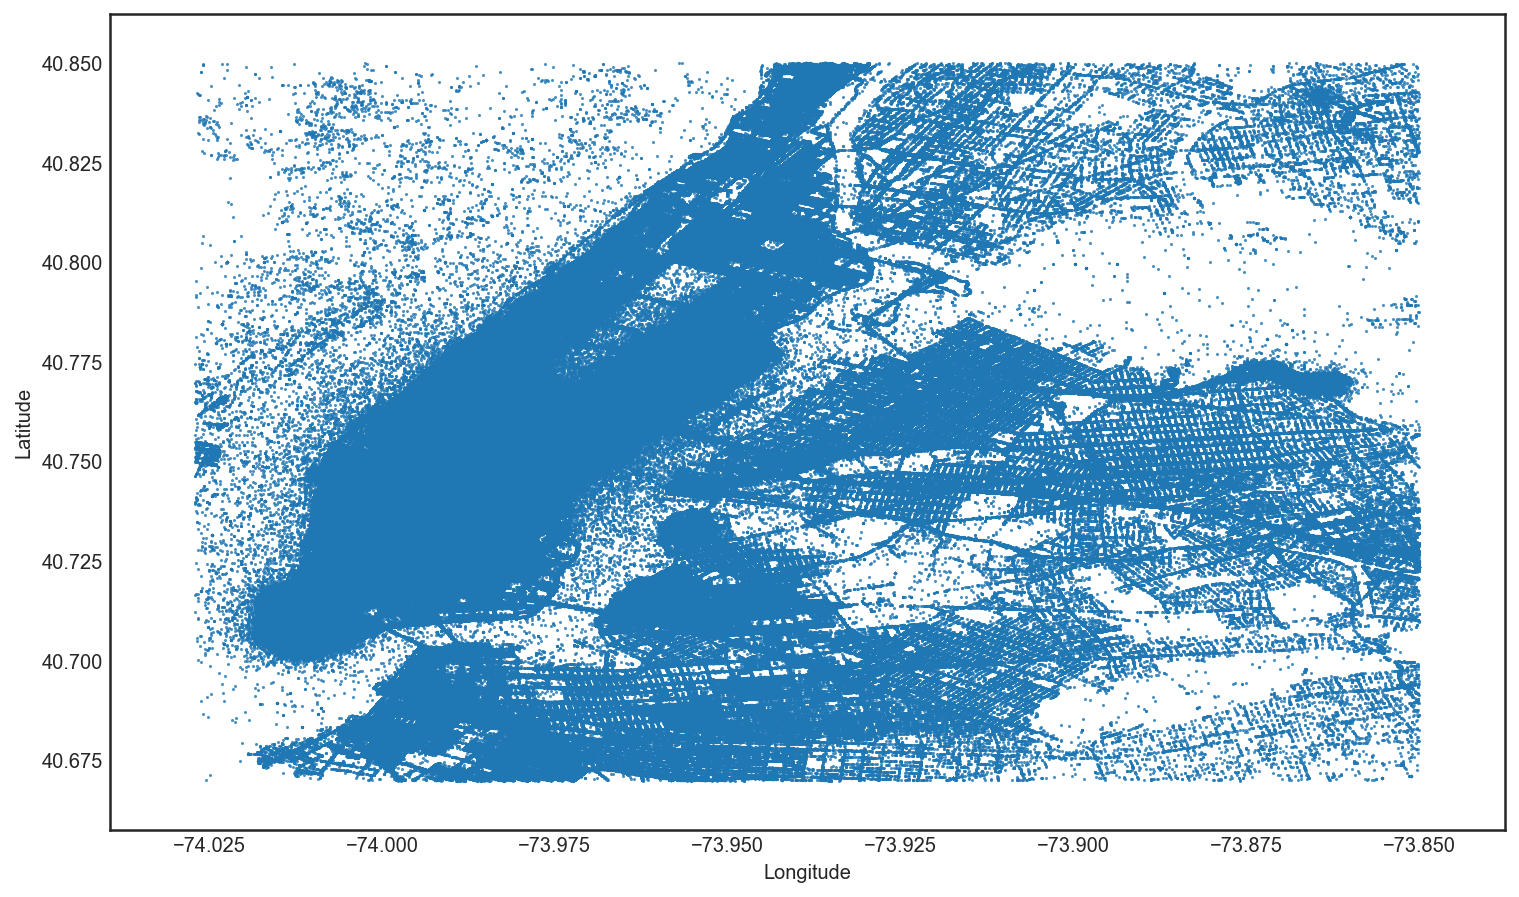

In [17]:
# Sanity Check Latitude and Longitude Values
longitude = list(trips_df2.pickup_longitude) + list(trips_df2.dropoff_longitude)
latitude = list(trips_df2.pickup_latitude) + list(trips_df2.dropoff_latitude)

trip_data2 = pd.DataFrame({'latitude': latitude, 'longitude': longitude})
sns.set_style("white")
fig, ax = plt.subplots(figsize=(12.5, 7.5))
ax = sns.regplot(x="longitude", y="latitude", data=trip_data2, scatter=True, fit_reg=False, scatter_kws={"s": 0.3})

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
None

In [18]:
# How many trips are 0 secs?
trips_df2[trips_df2.trip_time_in_secs==0].shape[0]

8521

In [19]:
# How many trips are 0 miles?
trips_df2[trips_df2.trip_distance==0].shape[0]

67594

In [20]:
trips_df2 = trips_df2[trips_df2.trip_time_in_secs>0]
trips_df2 = trips_df2[trips_df2.trip_distance>0.0]

In [21]:
trips_df2.passenger_count.value_counts()

1    9996918
2    1843000
5     838081
6     572427
3     571377
4     278106
0         15
9          1
Name: passenger_count, dtype: int64

**Notes:**
NYC Taxi Law prohibits more than 4 people in a 4-person taxicab, or more than 5 people in a 5 person taxicab. It is possible to have 6 people in a 5 person cab, if the sixth person is a child under seven and sits on the adult's lap, according to: http://www.nyc.gov/html/tlc/html/faq/faq_pass.shtml


1. Remove all trips where trip_time_in_secs = 0
2. Remove all trips where trip_distance = 0 miles
3. Remove all trips where passenger_count = 0 or 9 passengers

In [22]:
# All trips with 1 - 6 passengers
trips_df2 = trips_df2[(trips_df2.passenger_count > 0)&(trips_df2.passenger_count < 7)]
trips_df2.passenger_count.value_counts()

1    9996918
2    1843000
5     838081
6     572427
3     571377
4     278106
Name: passenger_count, dtype: int64

In [23]:
trips_df2.head()

,index,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,5558056,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:00:00,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064
3,12715560,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01 00:00:00,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028
6,12744782,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01 00:00:00,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716
7,12744785,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01 00:00:00,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711
8,12744788,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01 00:00:00,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556


In [24]:
trips_df2.describe()

,index,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,1.409991e+07,1.409991e+07,1.409991e+07,1.409991e+07,1.409991e+07,1.409991e+07,1.409991e+07,1.409991e+07,1.409991e+07
mean,7.556602e+06,1.003854e+00,1.711673e+00,6.987419e+02,2.432293e+00,-7.397875e+01,4.075286e+01,-7.397720e+01,4.075299e+01
std,4.356831e+06,2.148441e-01,1.389176e+00,4.605265e+02,2.254664e+00,2.344111e-02,2.298818e-02,2.392735e-02,2.568499e-02
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-7.402698e+01,4.067001e+01,-7.402699e+01,4.067000e+01
25%,3.795379e+06,1.000000e+00,1.000000e+00,3.600000e+02,1.030000e+00,-7.399250e+01,4.073791e+01,-7.399175e+01,4.073737e+01
50%,7.552780e+06,1.000000e+00,1.000000e+00,6.000000e+02,1.700000e+00,-7.398222e+01,4.075420e+01,-7.398089e+01,4.075462e+01
75%,1.133117e+07,1.000000e+00,2.000000e+00,9.000000e+02,2.940000e+00,-7.396901e+01,4.076823e+01,-7.396658e+01,4.076877e+01
max,1.510047e+07,2.100000e+02,6.000000e+00,1.057600e+04,1.000000e+02,-7.385001e+01,4.085000e+01,-7.385001e+01,4.085000e+01


In [25]:
trips_df2.shape[0]

14099909

## Load fares data from DB
---

In [26]:
query_string2 = '''
                select * from fares order by pickup_datetime asc
'''

In [27]:
# Connect to the existing fleetriskdb
con = sqlite3.connect('./DB/nyctaxidb.sqlite')
# Confirm data is being returned from this query
fare_data_df = pd.read_sql_query(query_string2, con)
# Verify that result of SQL query is stored in the dataframe
fare_data_df.tail()

,index,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
15100463,3246544,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,2013-04-30 23:59:57,CSH,5.5,0.5,0.5,0.00,0.0,6.50
15100464,2942655,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,2013-04-30 23:59:58,CRD,14.5,0.5,0.5,2.00,0.0,17.50
15100465,3007208,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,2013-04-30 23:59:58,CRD,4.0,0.5,0.5,1.00,0.0,6.00
15100466,3007664,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,2013-04-30 23:59:58,CRD,7.5,0.5,0.5,1.11,0.0,9.61
15100467,3246968,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,2013-04-30 23:59:58,CSH,7.5,0.5,0.5,0.00,0.0,8.50


In [28]:
con.close()

In [29]:
fare_data_df.shape[0]

15100468

## Scrub fares data for outliers, if any.

In [30]:
# Check for nulls
fares_df = fare_data_df.copy()
fares_df.isnull().sum()

index              0
medallion          0
hack_license       0
vendor_id          0
pickup_datetime    0
payment_type       0
fare_amount        0
surcharge          0
mta_tax            0
tip_amount         0
tolls_amount       0
total_amount       0
dtype: int64

In [31]:
fares_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15100468 entries, 0 to 15100467
Data columns (total 12 columns):
index              int64
medallion          object
hack_license       object
vendor_id          object
pickup_datetime    object
payment_type       object
fare_amount        float64
surcharge          float64
mta_tax            float64
tip_amount         float64
tolls_amount       float64
total_amount       float64
dtypes: float64(6), int64(1), object(5)
memory usage: 1.4+ GB


In [32]:
# Need to look into the $500 fare!
fares_df.describe()

,index,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.510047e+07,1.510047e+07,1.510047e+07,1.510047e+07,1.510047e+07,1.510047e+07,1.510047e+07
mean,7.550234e+06,1.227417e+01,3.266898e-01,4.983206e-01,1.345662e+00,2.446353e-01,1.468948e+01
std,4.359130e+06,9.958736e+00,3.673146e-01,2.892903e-02,2.131956e+00,1.185930e+00,1.194023e+01
min,0.000000e+00,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,3.775117e+06,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,7.550234e+06,9.500000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.100000e+01
75%,1.132535e+07,1.400000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.650000e+01
max,1.510047e+07,5.000000e+02,1.500000e+01,5.000000e-01,2.000000e+02,2.000000e+01,6.281000e+02


In [33]:
fares_df[fares_df.fare_amount == 500]

,index,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
208020,5900817,662302712A0D1A0CC0CFEE09C77E810A,C005B53076A215B1A73F409B17EC0A9C,CMT,2013-04-01 14:57:44,CRD,500.0,0.0,0.0,0.0,0.0,500.0
1982907,7174302,E1CCE8B14CCEE4F74AECD70A329FCE12,D047ADF5875661BFA8CF6B9832477424,CMT,2013-04-05 00:28:42,CRD,500.0,0.0,0.0,10.0,0.0,510.0
3982815,5938243,51E4B2515891E2A9B14B4A4EDCDD4A61,540881FB05E698CCB354C51563FF34FD,CMT,2013-04-09 02:42:32,CRD,500.0,0.0,0.0,100.0,0.0,600.0
6897450,5433524,D3BC1778F469C2671E9B68101D063080,F6DA525F59FA69F6E7843E2A471AE98E,CMT,2013-04-14 15:54:03,CRD,500.0,0.0,0.0,100.0,0.0,600.0
7956534,2138350,1109955CCAABCBCE1A22BCED5F1DBFF5,45D5908BA7B1E2F3BA424E66D81D7A30,CMT,2013-04-16 21:42:07,CRD,500.0,0.0,0.0,0.0,0.0,500.0
10994407,9287314,CA8DFBC7AF031CBABDD5A592DFB2741C,3C9179450CD0C023C36D35033062D894,CMT,2013-04-22 19:48:51,CRD,500.0,0.0,0.0,0.0,0.0,500.0
11167592,9287007,C2B48FE1ED15833D27B8C44667DDB878,9167C1802996E3C7D4E1777D46930646,CMT,2013-04-23 08:02:42,CRD,500.0,0.0,0.0,0.0,0.0,500.0
11265770,10286375,17A3D1C9C47C5B519AECCE5BB75625B4,C81E728D9D4C2F636F067F89CC14862C,CMT,2013-04-23 11:44:15,CSH,500.0,0.0,0.0,0.0,0.0,500.0
14825858,3225674,6203CEAAA0A019EB20A4D397DF014061,7DC21A197FECEFB70B2AE5E475A05030,CMT,2013-04-30 13:48:00,NOC,500.0,0.0,0.0,0.0,0.0,500.0


In [34]:
trips_df2.shape

(14099909, 14)

In [35]:
fares_df.shape

(15100468, 12)

## Merge Trips and Fares tables together
---

In [36]:
taxi_df = trips_df2.merge(fares_df, on=['medallion','hack_license','vendor_id','pickup_datetime'], how='inner')
taxi_df = taxi_df.drop(['index_x', 'index_y'], axis=1)
taxi_df.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:00:00,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01 00:00:00,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01 00:00:00,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01 00:00:00,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01 00:00:00,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5


In [37]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14100159 entries, 0 to 14100158
Data columns (total 20 columns):
medallion            object
hack_license         object
vendor_id            object
rate_code            int64
pickup_datetime      object
dropoff_datetime     object
passenger_count      int64
trip_time_in_secs    int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
payment_type         object
fare_amount          float64
surcharge            float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
total_amount         float64
dtypes: float64(11), int64(3), object(6)
memory usage: 2.2+ GB


In [38]:
taxi_df.isnull().sum()

medallion            0
hack_license         0
vendor_id            0
rate_code            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_time_in_secs    0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
payment_type         0
fare_amount          0
surcharge            0
mta_tax              0
tip_amount           0
tolls_amount         0
total_amount         0
dtype: int64

In [39]:
taxi_df.shape

(14100159, 20)

In [40]:
taxi_df.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07
mean,1.003856e+00,1.711671e+00,6.987400e+02,2.432294e+00,-7.397875e+01,4.075286e+01,-7.397720e+01,4.075299e+01,1.092214e+01,3.314330e-01,4.998537e-01,1.206128e+00,1.466119e-01,1.310617e+01
std,2.148501e-01,1.389173e+00,4.605280e+02,2.254677e+00,2.344112e-02,2.298819e-02,2.392732e-02,2.568501e-02,6.664937e+00,3.691019e-01,8.552866e-03,1.676072e+00,8.791101e-01,8.124970e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-7.402698e+01,4.067001e+01,-7.402699e+01,4.067000e+01,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,1.000000e+00,1.000000e+00,3.600000e+02,1.030000e+00,-7.399250e+01,4.073791e+01,-7.399175e+01,4.073737e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,1.000000e+00,1.000000e+00,6.000000e+02,1.700000e+00,-7.398222e+01,4.075420e+01,-7.398089e+01,4.075462e+01,9.000000e+00,5.000000e-01,5.000000e-01,1.000000e+00,0.000000e+00,1.080000e+01
75%,1.000000e+00,2.000000e+00,9.000000e+02,2.940000e+00,-7.396901e+01,4.076823e+01,-7.396658e+01,4.076877e+01,1.300000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.550000e+01
max,2.100000e+02,6.000000e+00,1.057600e+04,1.000000e+02,-7.385001e+01,4.085000e+01,-7.385001e+01,4.085000e+01,4.500100e+02,1.500000e+01,5.000000e-01,2.000000e+02,2.000000e+01,4.500100e+02


In [41]:
# Max fare amount is $450 - let's investigate
taxi_df[taxi_df.fare_amount == 450]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
2335387,29A25AEC480AEF1AFC7F00818D3A3FF5,C31309FBC712658C5E42537A123430F5,CMT,5,2013-04-05 23:06:49,2013-04-05 23:08:29,1,100,0.3,-74.002533,40.724911,-74.002533,40.724911,DIS,450.0,0.0,0.0,0.0,0.0,450.0


Use this data dictionary to determine what these codes mean, this seems like a 'Disputed' fare: http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf 

In [42]:
#taxi_df.payment_type.value_counts(normalize=True)

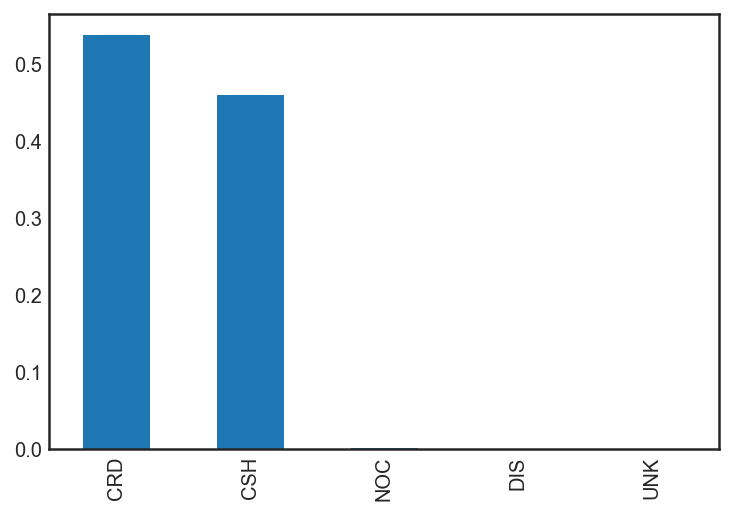

In [43]:
# Seems like a disputed fare - let's look at different payment types
taxi_df.payment_type.value_counts(normalize=True).plot(kind='bar')
None

In [44]:
# These other payment types make up a very small portion of our data
# Even though this will slightly bias our results, let's drop No Charge, Disputed or Unknown payment types
taxi_df = taxi_df[(taxi_df.payment_type == 'CRD')|(taxi_df.payment_type == 'CSH')]

In [45]:
taxi_df.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07
mean,1.003707e+00,1.712761e+00,6.989239e+02,2.432126e+00,-7.397875e+01,4.075286e+01,-7.397721e+01,4.075299e+01,1.092205e+01,3.313664e-01,4.998644e-01,1.208341e+00,1.465603e-01,1.310818e+01
std,2.141330e-01,1.390191e+00,4.602143e+02,2.251872e+00,2.343296e-02,2.298477e-02,2.391404e-02,2.567917e-02,6.653930e+00,3.691043e-01,8.232770e-03,1.676601e+00,8.787895e-01,8.117006e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-7.402698e+01,4.067001e+01,-7.402699e+01,4.067000e+01,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,1.000000e+00,1.000000e+00,3.600000e+02,1.030000e+00,-7.399250e+01,4.073791e+01,-7.399175e+01,4.073737e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,1.000000e+00,1.000000e+00,6.000000e+02,1.700000e+00,-7.398222e+01,4.075420e+01,-7.398089e+01,4.075463e+01,9.000000e+00,5.000000e-01,5.000000e-01,1.000000e+00,0.000000e+00,1.080000e+01
75%,1.000000e+00,2.000000e+00,9.000000e+02,2.940000e+00,-7.396902e+01,4.076823e+01,-7.396660e+01,4.076878e+01,1.300000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.550000e+01
max,2.100000e+02,6.000000e+00,1.057600e+04,1.000000e+02,-7.385001e+01,4.085000e+01,-7.385001e+01,4.085000e+01,4.500100e+02,1.500000e+01,5.000000e-01,2.000000e+02,2.000000e+01,4.500100e+02


# Save Results to SQLite Database

In [136]:
import sqlite3
# Create a sqlite3 connection to nyctaxidb
cnxn = sqlite3.connect('nyctaximergeddb.sqlite')

In [137]:
# Create trips table
taxi_df.to_sql('merged',cnxn)